In [78]:
import os
import pandas as pd
from datetime import datetime
import numpy as np
import numpy.random as random
import scipy as sp
from scipy import stats
from scipy import integrate
from pandas import Series, DataFrame
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
import matplotlib as mlp
import matplotlib.pyplot as plt
import japanize_matplotlib
import math
from random import Random

In [79]:
def agg_data_for_unit():
    data_sets = pd.DataFrame()
    beacon_files = os.listdir('raw_data/')
    pos_files = os.listdir('POS_RAW_data/')

    beacon_files.sort()
    pos_files.sort()
    
    if beacon_files[0] == ".DS_Store":
        beacon_files.pop(0)

    if pos_files[0] == ".DS_Store":
        pos_files.pop(0)

    pos_files = list(map(lambda x: x[:14], pos_files))[::2]

    for beacon_file, pos_file in zip(beacon_files, pos_files):
        date_beacon = beacon_file[9:17]
        date_pos    = pos_file[6:14]

        if date_beacon != date_pos:
            continue
        else:
            date = date_beacon
        
        t_start = datetime.strptime(f'{date} 09:00', '%Y%m%d %H:%M').timestamp()
        t_end   = datetime.strptime(f'{date} 21:00', '%Y%m%d %H:%M').timestamp()
        rssi    = 70
        beacon_data = pd.read_csv(f"raw_data/{beacon_file}")
        pos_data1 = pd.read_csv(f"POS_RAW_data/{pos_file}_01.csv")
        pos_data2 = pd.read_csv(f"POS_RAW_data/{pos_file}_02.csv")

        pos_data1 = pos_data1[["商品コード", "商品名称（または券名称）", "単価", "数量", "合計金額"]]
        pos_data2 = pos_data2[["商品コード", "商品名称（または券名称）", "単価", "数量", "合計金額"]]
        pos_data  = pd.concat([pos_data1, pos_data2])

        pos_data[["単価", "数量", "合計金額"]] = pos_data[["単価", "数量", "合計金額"]].map(lambda x: int(x))
        pos_data = pos_data.groupby(["商品コード", "商品名称（または券名称）"]).sum()

        pos_data["単価"] = pos_data["合計金額"] / pos_data["数量"]
        pos_data["単価"] = pos_data["単価"].astype(int)

        beacon_data.columns = ["No.", "mac-address", "distance", "rssi", "random", "timestamp"]
        beacon_data = beacon_data[beacon_data["random"] == 1]
        beacon_data = beacon_data[beacon_data["timestamp"] >= t_start]
        beacon_data = beacon_data[beacon_data["timestamp"] <= t_end]
        beacon_data = beacon_data[beacon_data["rssi"] < rssi]
        beacon_data = beacon_data.drop_duplicates("mac-address")

        per_unit = pd.DataFrame(
            {
                "date":[date],
                "総ビーコン数": [len(beacon_data)],
                "総売上点数": [pos_data["数量"].sum()],
                "総売上": [pos_data["合計金額"].sum()],
            }
        )
        data_sets = pd.concat([data_sets, per_unit])

    return data_sets.reset_index(drop=True)

In [80]:
def poisson_distribution(lambda_, k):
    return stats.poisson.pmf(round(k), lambda_)

def normal_distribution(x, mu, sigma):
    return 1 / np.sqrt(2 * np.pi * (sigma ** 2)) * np.exp(-((x - mu) ** 2) / (2 * (sigma ** 2)))

def uniform_distribution(x, alpha, beta):
    if alpha > beta:
        alpha, beta = beta, alpha

    if (alpha <= x) and (x <= beta):
        return 1 / (beta - alpha)
    else:
        return 0.0

In [81]:
class Full_Model_On_Bayes:
    def __init__(self, random_state=None):
        self.alpha   = np.array([], dtype=np.float64)
        self.alpha0  = 0.0
        self.random_dict = {}
        self.gauss_s = 0.1
        self.sampling_alpha   = np.array([], dtype=np.float64)
        self.sampling_alpha0  = np.array([], dtype=np.float64)
        self.sampling_gauss_s = np.array([], dtype=np.float64)
        self.sampling_random_dict = {}

        if random_state != None:
            self.random = np.random
            self.random.seed(seed=random_state)
        else:
            self.random = np.random

    def sampling(self, x_train, r_train, y_train, scale=1, iter_num=1e6, burnin=1e3, thin_num=5):
        if (x_train.ndim != 2) or (r_train.ndim != 2) or (y_train.ndim != 1):
            print(f"x_train dims = {x_train.ndim}")
            print(f"r_train dims = {r_train.ndim}")
            print(f"y_train dims = {y_train.ndim}")
            print("エラー：：次元数が一致しません。")
            return False

        if (x_train.shape[0] != r_train.shape[0]) or (x_train.shape[0] != y_train.shape[0]):
            print(f"x_train shape = {x_train.shape}")
            print(f"r_train shape = {r_train.shape}")
            print(f"y_train shape = {y_train.shape}")
            print("エラー：：次元数が一致しません。")
            return False

        if type(x_train) is pd.core.frame.DataFrame:
            x_train = x_train.to_numpy()

        if type(r_train) is pd.core.frame.DataFrame:
            for elem1 in r_train.columns.values:
                r_train[elem1] = r_train[elem1].factorize()[0]
            r_train = r_train.to_numpy()

            for elem1 in range(0, r_train.shape[1]):
                for elem2 in r_train[:, elem1]:
                    self.random_dict[elem1, elem2] = 0.0

        if type(y_train) is pd.core.series.Series:
            y_train = y_train.to_numpy()

        num, s = x_train.shape
        y_train = y_train.reshape([num, 1])
        

        #正規方程式
        A = np.hstack([x_train, np.ones([num, 1])])
        b = np.log(y_train).reshape([num])

        x = np.dot(np.linalg.inv(np.dot(A.T, A)), np.dot(A.T, b))
        self.alpha, self.alpha0 = x[0:s].reshape([1, s]), x[s]
        self.gauss_s            = 0.1

        lambda_vec  = np.exp(np.sum(self.alpha * x_train, axis=1) + self.alpha0)
        lambda_vec  = lambda_vec.reshape([num, 1])

        def vectorlize_non_quad(idx1, lambda_, y_train_indi, gauss_s, random_dict):
            lambda_r  = lambda_
            normal_r  = 1.0
            for idx2 in range(0, r_train.shape[1]):
                lambda_r = lambda_r * np.exp(random_dict[idx2, r_train[idx1, idx2]])
                normal_r = normal_r * normal_distribution(random_dict[idx2, r_train[idx1, idx2]], 0, gauss_s)
            poisson   = poisson_distribution(lambda_r, y_train_indi)

            tmp = poisson * normal_r
            tmp = np.log(tmp + 1e-16)
            return tmp
        
        py_vectorlize_non_quad = np.frompyfunc(vectorlize_non_quad, 5, 1)
        now_likelihood = py_vectorlize_non_quad(np.arange(0,num,1).reshape([num, 1]), lambda_vec, y_train, self.gauss_s, self.random_dict)
        now_likelihood = now_likelihood.astype(float).reshape([num, 1])
        now_likelihood = np.sum(now_likelihood)


        now_ite  = 0
        thin_ite = 0
        while now_ite < iter_num:
            rnd_alpha   = self.random.normal(loc=0, scale=scale, size=(1, s + 1))
            rnd_gauss_s = self.random.normal(loc=0, scale=scale)
            tmp_alpha, tmp_alpha0 = self.alpha + rnd_alpha[0, 0:s], self.alpha0 + rnd_alpha[0, s]
            tmp_gauss_s           = np.abs(self.gauss_s + rnd_gauss_s)

            tmp_random_dict = {}
            for key in self.random_dict.keys():
                tmp_random_dict[key] = self.random_dict[key] + self.random.normal(loc=0, scale=scale)

            if np.any((np.sum(tmp_alpha * x_train, axis=1) + tmp_alpha0) > 600) == True:
                max_num = np.max(np.sum(tmp_alpha * x_train, axis=1) + tmp_alpha0)
                tmp_alpha  = tmp_alpha  / max_num * 600
                tmp_alpha0 = tmp_alpha0 / max_num * 600

                for key in self.random_dict.keys():
                    tmp_random_dict[key] = tmp_random_dict[key] / max_num * 600

            lambda_vec  = np.exp(np.sum(tmp_alpha * x_train, axis=1) + tmp_alpha0)
            lambda_vec  = lambda_vec.reshape([num, 1])

            tmp_likelihood = py_vectorlize_non_quad(np.arange(0,num,1).reshape([num, 1]), lambda_vec, y_train, tmp_gauss_s, tmp_random_dict)
            tmp_likelihood = tmp_likelihood.astype(float).reshape([num, 1])
            tmp_likelihood = np.sum(tmp_likelihood)

            tmp_rand = self.random.random()
            tmp_rate = np.abs(tmp_likelihood - (np.log(1e-16)*num)) / (np.abs(now_likelihood - (np.log(1e-16)*num)) + 1e-16)
            if tmp_rand < tmp_rate:

                if now_ite % 100 == 0:
                    print(f"現在ite:{now_ite}  保存サンプリング数:{len(self.sampling_alpha0)}")
                
                self.alpha, self.alpha0 = tmp_alpha, tmp_alpha0
                self.gauss_s            = tmp_gauss_s
                now_likelihood          = tmp_likelihood

                for key in self.random_dict.keys():
                    self.random_dict[key] = tmp_random_dict[key]

                if now_ite > burnin:
                    if thin_ite % thin_num == 0:
                        if now_ite == (burnin + 1):
                            self.sampling_alpha   = np.array(self.alpha).reshape(  [1, s])
                            self.sampling_alpha0  = np.array(self.alpha0).reshape( [1, 1])
                            self.sampling_gauss_s = np.array(self.gauss_s).reshape([1, 1])

                            for key in self.random_dict.keys():
                                self.sampling_random_dict[key] = np.array(self.random_dict[key]).reshape([1, 1])
                        else:
                            self.sampling_alpha   = np.vstack((self.sampling_alpha,   self.alpha))
                            self.sampling_alpha0  = np.vstack((self.sampling_alpha0,  self.alpha0))
                            self.sampling_gauss_s = np.vstack((self.sampling_gauss_s, self.gauss_s))

                            for key in self.random_dict.keys():
                                self.sampling_random_dict[key] = np.vstack((self.sampling_random_dict[key], self.random_dict[key]))
                    thin_ite = thin_ite + 1
                now_ite  = now_ite  + 1

        return True

    def predict(self, x_test, r_test, sample=100, step=1):
        if type(x_test) is pd.core.frame.DataFrame:
            x_test = x_test.to_numpy()

        if type(r_test) is pd.core.frame.DataFrame:
            for elem1 in r_test.columns.values:
                r_test[elem1] = r_test[elem1].factorize()[0]
            r_test = r_test.to_numpy()

        num, _ = x_test.shape
        self.alpha   = np.mean(self.sampling_alpha,   axis=0).reshape(self.alpha.shape)
        self.alpha0  = np.mean(self.sampling_alpha0,  axis=0).reshape(self.alpha0.shape)
        self.gauss_s = np.mean(self.sampling_gauss_s, axis=0).reshape(self.gauss_s.shape)

        for key in self.random_dict.keys():
            self.random_dict[key] = np.mean(self.sampling_random_dict[key], axis=0).reshape(self.random_dict[key].shape)
        
        lambda_vec = np.exp(np.sum(self.alpha * x_test, axis=1) + self.alpha0)
        def vectorlize_non_quad(idx1, lambda_, y_train_indi, gauss_s, random_dict):
            lambda_r  = lambda_
            normal_r  = 1.0
            for idx2 in range(0, r_test.shape[1]):
                lambda_r = lambda_r * np.exp(random_dict[idx2, r_test[idx1, idx2]])
                normal_r = normal_r * normal_distribution(random_dict[idx2, r_test[idx1, idx2]], 0, gauss_s)
            poisson   = poisson_distribution(lambda_r, y_train_indi)

            tmp = poisson * normal_r
            return y_train_indi, tmp

        y_test_mat = (lambda_vec - sample/2 * step).reshape([len(lambda_vec), 1])
        lambda_mat = (lambda_vec                  ).reshape([len(lambda_vec), 1])
        for ite in np.arange(-sample / 2 * step + step, sample / 2 * step, step):
            y_test_mat = np.hstack([y_test_mat, (lambda_vec + ite).reshape([len(lambda_vec), 1])])
            lambda_mat = np.hstack([lambda_mat, (lambda_vec      ).reshape([len(lambda_vec), 1])])

        pred_mat  = np.frompyfunc(vectorlize_non_quad, 5, 2)(np.arange(0,num,1).reshape([num, 1]), lambda_mat, y_test_mat, self.gauss_s, self.random_dict)
        pred_y    = pred_mat[0].astype(float)
        pred_prob = pred_mat[1].astype(float)

        return pred_y, pred_prob

In [82]:
data_sets = agg_data_for_unit()
data_sets["場所差"] = "カフェドクリエ京都四条店"
data_sets["個体差"] = data_sets["date"] + " " + data_sets["場所差"]

X = data_sets.drop(["date", "総売上点数", "総売上"], axis=1)
y = data_sets["総売上点数"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

model = Full_Model_On_Bayes()
model.sampling(X_train.drop(["個体差", "場所差"], axis=1), X_train.drop(["総ビーコン数"], axis=1), y_train, scale=0.01, iter_num=100000, burnin=1000, thin_num=100)

現在ite:0  保存サンプリング数:0
現在ite:100  保存サンプリング数:0
現在ite:200  保存サンプリング数:0
現在ite:300  保存サンプリング数:0
現在ite:400  保存サンプリング数:0
現在ite:500  保存サンプリング数:0
現在ite:600  保存サンプリング数:0
現在ite:700  保存サンプリング数:0
現在ite:800  保存サンプリング数:0
現在ite:900  保存サンプリング数:0
現在ite:1000  保存サンプリング数:0
現在ite:1100  保存サンプリング数:1
現在ite:1200  保存サンプリング数:2
現在ite:1300  保存サンプリング数:3
現在ite:1400  保存サンプリング数:4
現在ite:1500  保存サンプリング数:5
現在ite:1600  保存サンプリング数:6
現在ite:1700  保存サンプリング数:7
現在ite:1800  保存サンプリング数:8
現在ite:1900  保存サンプリング数:9
現在ite:2000  保存サンプリング数:10
現在ite:2100  保存サンプリング数:11
現在ite:2200  保存サンプリング数:12
現在ite:2300  保存サンプリング数:13
現在ite:2400  保存サンプリング数:14
現在ite:2500  保存サンプリング数:15
現在ite:2600  保存サンプリング数:16
現在ite:2700  保存サンプリング数:17
現在ite:2800  保存サンプリング数:18
現在ite:2900  保存サンプリング数:19
現在ite:3000  保存サンプリング数:20
現在ite:3100  保存サンプリング数:21
現在ite:3200  保存サンプリング数:22
現在ite:3300  保存サンプリング数:23
現在ite:3400  保存サンプリング数:24
現在ite:3500  保存サンプリング数:25
現在ite:3600  保存サンプリング数:26
現在ite:3700  保存サンプリング数:27
現在ite:3800  保存サンプリング数:28
現在ite:3900  保存サンプリング数:29
現在ite:4000  保存サンプリング数:30
現在ite:4

True

Statistics information
          mean      median      std    
alpha     -0.00020   -0.00019     0.00062
alpha0    5.73509   5.77181     1.04178
gauss_s   1.51043   1.31663     0.82555

quartiles
          2.5%    25%      50%      75%      97.5%
alpha     -0.00230 -0.00060  -0.00019  0.00020  0.00175
alpha0    2.96271 5.21651  5.77181  6.28544  8.53277
gauss_s   0.04793 0.86921  1.31663  2.15922  3.66566


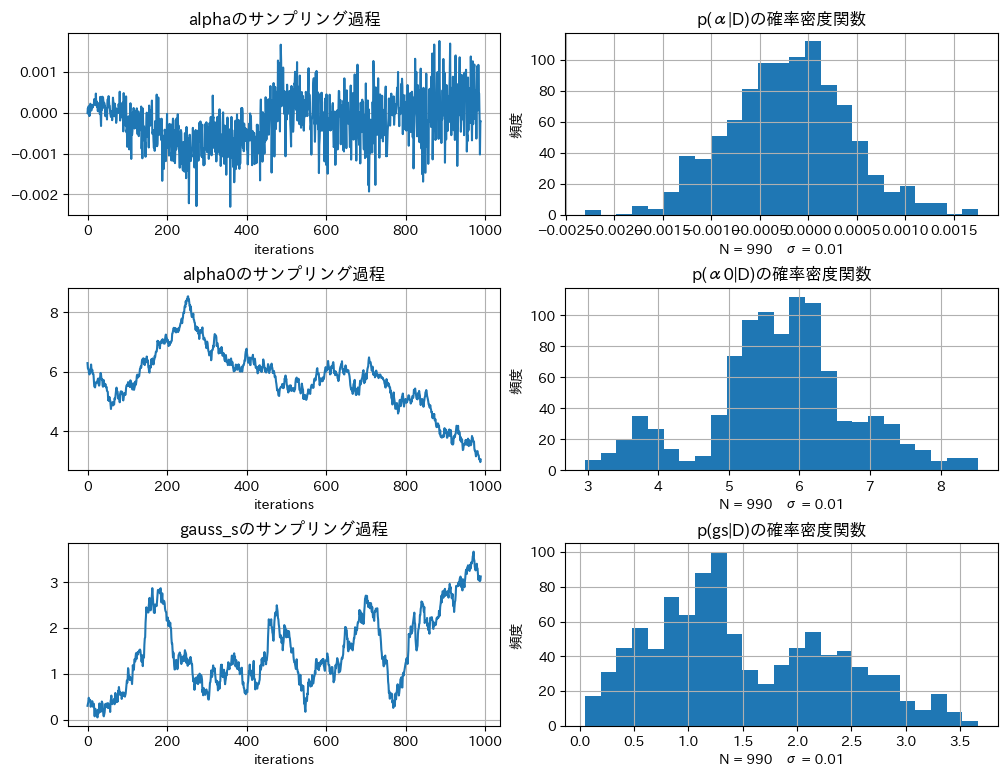

In [83]:
plt.figure(figsize=(12, 9))
plt.subplots_adjust(wspace=0.15,hspace=0.4)

plt.subplot(3,2,1)
plt.plot(np.arange(0, model.sampling_alpha.shape[0], 1), model.sampling_alpha)
plt.title("alphaのサンプリング過程")
plt.xlabel("iterations")
plt.grid(True)

plt.subplot(3,2,2)
plt.hist(model.sampling_alpha[:, 0], bins=25)
plt.title("p(α|D)の確率密度関数")
plt.xlabel(f"N = {model.sampling_alpha.shape[0]}   σ = {0.01}")
plt.ylabel("頻度")
plt.grid(True)

plt.subplot(3,2,3)
plt.plot(np.arange(0, model.sampling_alpha0.shape[0], 1), model.sampling_alpha0)
plt.title("alpha0のサンプリング過程")
plt.xlabel("iterations")
plt.grid(True)

plt.subplot(3,2,4)
plt.hist(model.sampling_alpha0, bins=25)
plt.title("p(α0|D)の確率密度関数")
plt.xlabel(f"N = {model.sampling_alpha0.shape[0]}   σ = {0.01}")
plt.ylabel("頻度")
plt.grid(True)

plt.subplot(3,2,5)
plt.plot(np.arange(0, model.sampling_gauss_s.shape[0], 1), model.sampling_gauss_s)
plt.title("gauss_sのサンプリング過程")
plt.xlabel("iterations")
plt.grid(True)

plt.subplot(3,2,6)
plt.hist(model.sampling_gauss_s, bins=25)
plt.title("p(gs|D)の確率密度関数")
plt.xlabel(f"N = {model.sampling_gauss_s.shape[0]}   σ = {0.01}")
plt.ylabel("頻度")
plt.grid(True)

print("Statistics information")
print("          mean      median      std    ")
print("alpha     {:.5f}   {:.5f}     {:.5f}".format(np.mean(model.sampling_alpha  ), np.median(model.sampling_alpha  ), np.std(model.sampling_alpha  )))
print("alpha0    {:.5f}   {:.5f}     {:.5f}".format(np.mean(model.sampling_alpha0 ), np.median(model.sampling_alpha0 ), np.std(model.sampling_alpha0 )))
print("gauss_s   {:.5f}   {:.5f}     {:.5f}".format(np.mean(model.sampling_gauss_s), np.median(model.sampling_gauss_s), np.std(model.sampling_gauss_s)))
print("")

p_alpha   = np.percentile(model.sampling_alpha,   q=[0, 25, 50, 75, 100])
p_alpha0  = np.percentile(model.sampling_alpha0,  q=[0, 25, 50, 75, 100])
p_gauss_s = np.percentile(model.sampling_gauss_s, q=[0, 25, 50, 75, 100])
print("quartiles")
print("          2.5%    25%      50%      75%      97.5%")
print("alpha     {:.5f} {:.5f}  {:.5f}  {:.5f}  {:.5f}".format(p_alpha[0],   p_alpha[1],   p_alpha[2],   p_alpha[3],   p_alpha[4]))
print("alpha0    {:.5f} {:.5f}  {:.5f}  {:.5f}  {:.5f}".format(p_alpha0[0],  p_alpha0[1],  p_alpha0[2],  p_alpha0[3],  p_alpha0[4]))
print("gauss_s   {:.5f} {:.5f}  {:.5f}  {:.5f}  {:.5f}".format(p_gauss_s[0], p_gauss_s[1], p_gauss_s[2], p_gauss_s[3], p_gauss_s[4]))

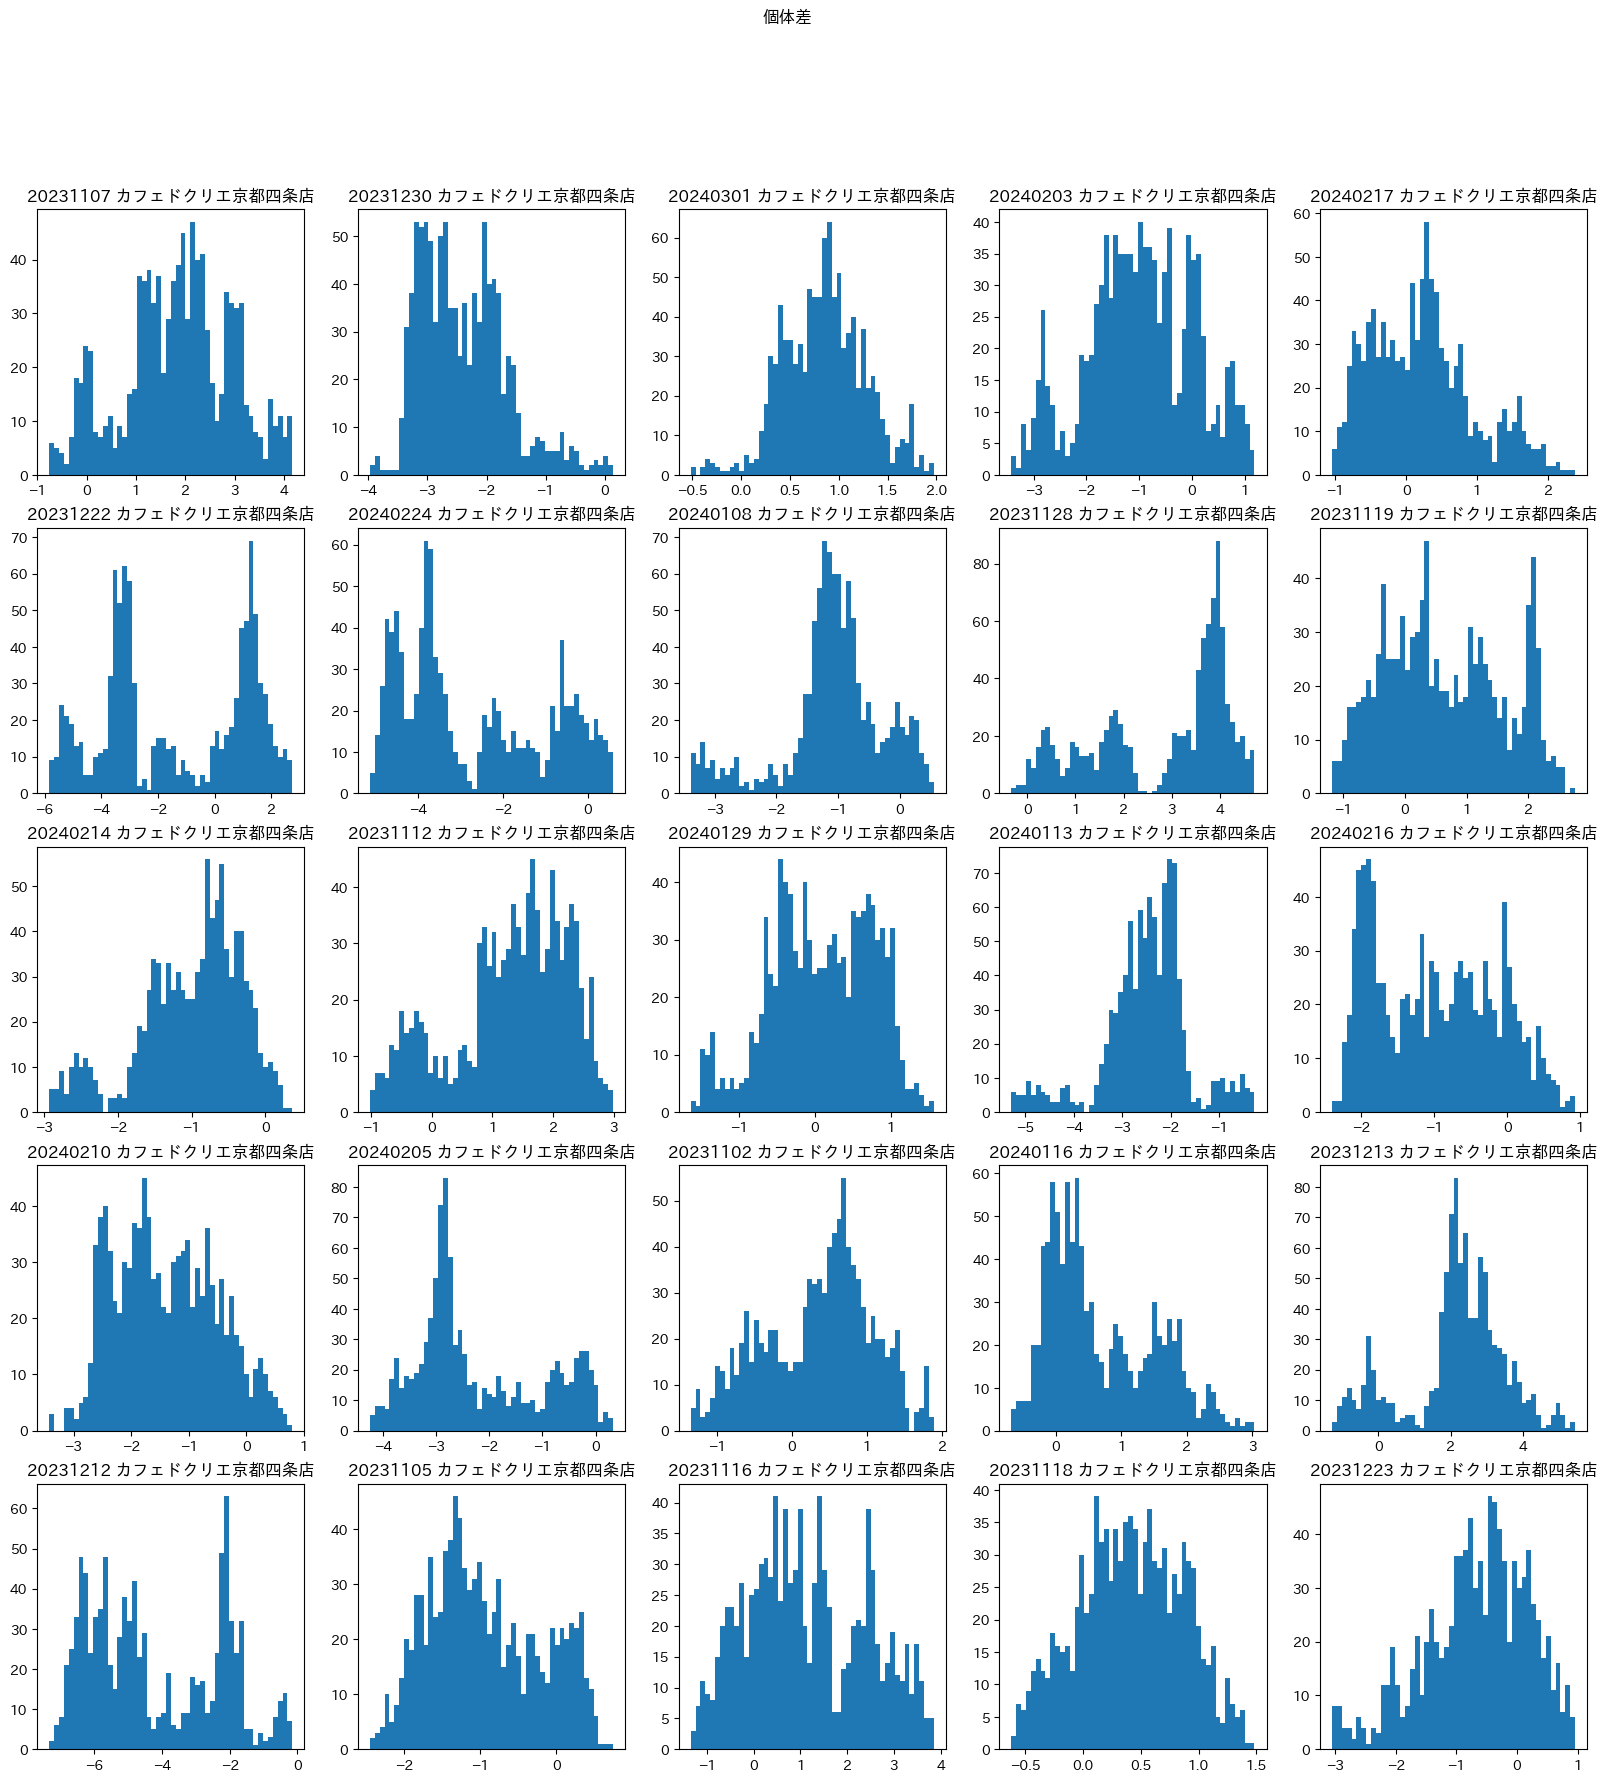

In [84]:
fig, axes = plt.subplots(5, 5, figsize=(20, 20))
ax = axes.ravel()
sampling_random_dict = model.sampling_random_dict
dict_keys = list(sampling_random_dict)

tmp_x_train = X_train.drop(["総ビーコン数"], axis=1)
tmp_x_train["場所差-factorize"] = tmp_x_train["場所差"].factorize()[0]
tmp_x_train["個体差-factorize"] = tmp_x_train["個体差"].factorize()[0]
tmp_x_train = tmp_x_train.reset_index(drop=True)

fig.suptitle("個体差")
for idx in range(0, 25):
    col, data = dict_keys[idx + 1]

    title = tmp_x_train[tmp_x_train["個体差-factorize"] == data]["個体差"].values[0]
    
    ax[idx].hist(model.sampling_random_dict[dict_keys[idx]], bins=50)
    ax[idx].set_title(title)

Text(0.5, 0, 'カフェドクリエ京都四条店')

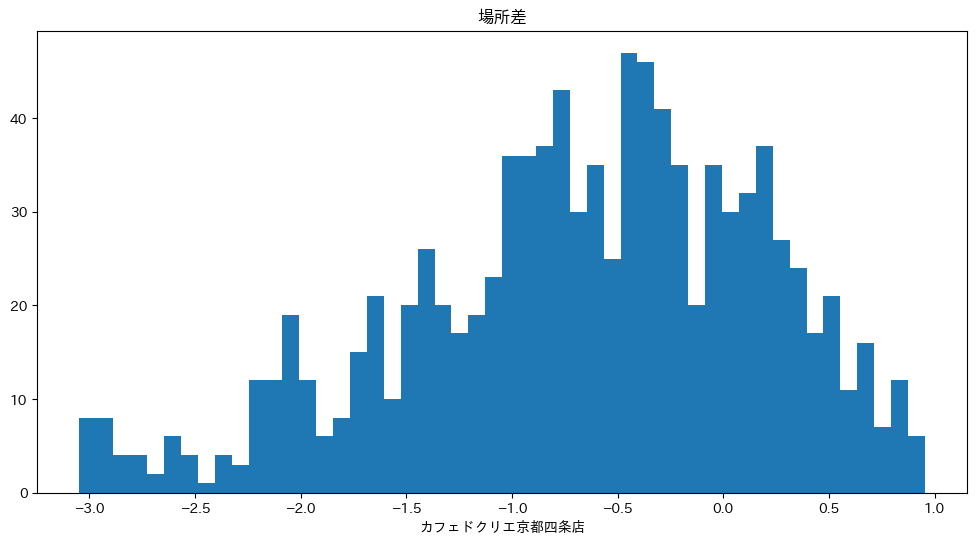

In [85]:
plt.figure(figsize=(12,6))
plt.title("場所差")
col, data = dict_keys[idx + 1]
title = tmp_x_train[tmp_x_train["場所差-factorize"] == 0]["場所差"].values[0]

plt.hist(model.sampling_random_dict[dict_keys[idx]], bins=50)
plt.xlabel(title)